### Test 2: Train a random forest regressor on per-file features calculated by FeatureCalculate class
FeatureCalculate contains some featurs from tsfresh and some from Qingkai's code  
This is expected to produce similar results to before, but worth checking if the new features make a difference 

In [3]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [11]:
feature_files = glob.glob('rms_fcalc/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[1].split('.')[0][:-10]
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

In [12]:
def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['file_name']]
    opdf = opdf.assign(mean_col = indf.drop('file_name',axis=1).mean(axis=1))
    opdf.columns = ['file_name',newcolname]
    
    return opdf

In [13]:
indf = lineCSN_M3
for feature_df in feature_dfs:
    
    mean_feature = extract_mean_over_channels(feature_df)
    merged_df = pd.merge(indf,mean_feature,on='file_name')
    indf = merged_df

In [15]:
merged_df.index = lineCSN_M3.index

In [16]:
merged_df.head()

,file_name,M3_20_Avg_interp,Temphigh_interp,mean_median,mean_minimum,mean_abs_energy,mean_root_mean_square,mean_mean,mean_cid_ce,mean_mean_change,mean_x_crossing_m,mean_skewness,mean_kurtosis,mean_maximum,mean_mean_abs_change,mean_variance,mean_interquartile_range
DateTime,,,,,,,,,,,,,,,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489,-0.256883,-146.639777,1.337353e+06,23.063935,-0.269010,1609.141030,0.000384,1226.15,-0.029094,7.133960,142.298574,20.637504,557.145765,16.598357
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656,-0.089357,-244.519483,1.936504e+06,27.941960,-0.181803,1966.166111,0.024688,1257.45,-0.020735,19.883738,238.815942,19.770928,806.832323,12.428674
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822,-0.201373,-401.599379,3.117734e+06,35.140439,-0.163673,2522.915228,0.017649,1242.05,-0.097259,33.186354,414.522634,29.673234,1298.861278,24.788902
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989,-0.275406,-253.386998,3.048996e+06,35.241241,-0.417050,2680.393873,0.002172,1308.15,-0.188153,7.752490,236.810422,34.666330,1268.854153,27.470094
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156,-0.176445,-74.926399,4.470121e+05,13.488263,-0.214455,983.665690,-0.001794,1252.65,0.011424,3.741794,74.338417,13.399776,186.202829,11.061511


These files had their median values removed before processing, which explains why the features look different here

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [31]:
cleaned_df = merged_df.dropna()
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [41]:
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=100,oob_score=True,n_jobs=2)

In [42]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [43]:
print(regr.feature_importances_)

[0.13588339 0.03856179 0.01361215 0.02665456 0.22371874 0.07751246
 0.03994195 0.15403739 0.04000013 0.05094407 0.04056009 0.04470762
 0.01321351 0.10065214]


In [44]:
print(regr.oob_score_)

0.055142020789129664


In [45]:
regr.score(X_test,y_test)

0.05190503960362369

In [46]:
regr_pred = regr.predict(X_test)

Text(0,0.5,'Actual')

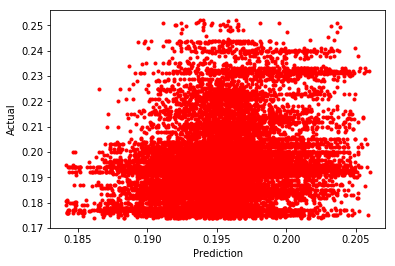

In [47]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

Again, the fit is poor - very much the same as in the case of the old feature choices. We could try filtering the feature time series though

Test with the temperature dataset

In [48]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=200,oob_score=True,n_jobs=2)

In [49]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=200, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [50]:
print(regr.feature_importances_)

[0.17853202 0.00695928 0.00343459 0.00327248 0.23360644 0.00436689
 0.00715367 0.36299276 0.00817801 0.04216779 0.00908433 0.01248937
 0.00305176 0.12471062]


In [51]:
print(regr.oob_score_) 

0.17840912615117155


In [52]:
regr_pred = regr.predict(X_test)
regr.score(X_test,y_test)

0.18292203713373112

Text(0,0.5,'Actual')

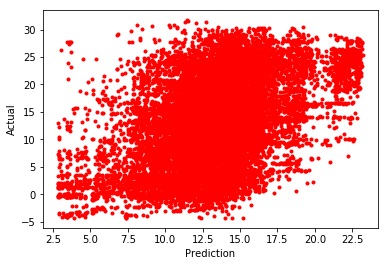

In [53]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

Temperature prediction with these features is actually slightly better than in test 1

### lets try the filtering test again 

In [54]:
from scipy.signal import butter, lfilter

In [55]:
def butter_lowpass(cutoff,fs,order=4):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order,normal_cutoff,btype='low')
    return b,a

def butter_lowpass_filter(data,cutoff,fs,order=4):
    b,a = butter_lowpass(cutoff,fs,order=order)
    y = lfilter(b,a,data)
    return y


In [57]:
fs = 0.0167 #sampling every minute
cutoff = 0.0001 #we want to smooth the ts

In [58]:
filtered_df = pd.DataFrame()
filtered_df['file_name'] = cleaned_df['file_name']
filtered_df['M3_20_Avg_interp'] = cleaned_df['M3_20_Avg_interp']
filtered_df['Temphigh_interp'] = cleaned_df['Temphigh_interp']

for column in cleaned_df.columns[3:]:
    cname = str(column)
    filtered_df[cname] = butter_lowpass_filter(cleaned_df[cname].values,cutoff,fs)

In [67]:
y = filtered_df['Temphigh_interp']
X = filtered_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#Note that when training on the filtered dataset we need to decrease min_samples_leaf in order to get a 
#better training score

regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=10,oob_score=True,n_jobs=2)

In [68]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [69]:
print(regr.feature_importances_)

[0.07833632 0.03012093 0.02511408 0.01665883 0.08539667 0.01562768
 0.08136927 0.32429289 0.08133061 0.13916559 0.03390905 0.0188122
 0.02322274 0.04664314]


In [70]:
print(regr.oob_score_) 

0.9608382172451891


In [71]:
regr.score(X_test,y_test)

0.9597248417636347

In [72]:
regr_pred = regr.predict(X_test)

Text(0,0.5,'Actual')

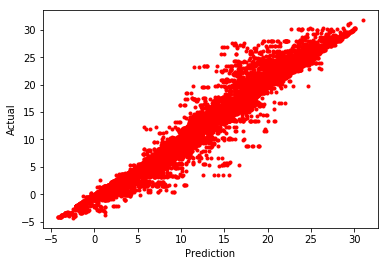

In [73]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [74]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, r2_score

In [75]:
mean_absolute_error(y_test,regr_pred)

0.8399060681373448

In [76]:
mean_squared_error(y_test,regr_pred)

2.2148934687887376

In [77]:
explained_variance_score(y_test,regr_pred)

0.9597256870730789

In [78]:
r2_score(y_test,regr_pred)

0.9597248417636347

By all variance metrics, this is a good fit. Would be interesting to see how well this model does on a completely new DAS dataset - we could test this